In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sys import path
from os.path import abspath
path.append(abspath("/home/ng136/nico"))
import ng_functions as ng

from glob import glob
from pathlib import Path
import warnings
from time import time
from tqdm import tqdm

In [3]:
rnadata = sc.read('/n/groups/klein/nico/neutrophils/data/exp2_totalseq/neutrophils_totalseq_01292021_rna.h5ad')
adtdata = sc.read('/n/groups/klein/nico/neutrophils/data/exp2_totalseq/neutrophils_totalseq_01292021_adt.h5ad')
muxdata = sc.read('/n/groups/klein/nico/neutrophils/data/exp2_totalseq/neutrophils_totalseq_01292021_mux.h5ad')



In [33]:
start = time()

rnadict = {sample_id : rnadata[rnadata.obs["sampleID"] == sample_id] for sample_id in np.unique(rnadata.obs.sampleID)}

with warnings.catch_warnings(record=True):
    
    mito_genes = rnadata.var_names[rnadata.var_names.str.contains('mt-')]
    
    for i,(lib_id, adata) in enumerate(tqdm(rnadict.items())):
        
        adata.var_names_make_unique() # check it's the same across libraries!!!!        

        # calculate total unnormalized umi per cell
        adata.obs['n_counts'] = np.array(adata.X.sum(1)).reshape(-1)
        
        # calculate genes with >0 counts for each cell
        adata.obs['n_genes'] = np.array((adata.X != 0).sum(1)).flatten()
        
        # calculate mitochondrial umi fraction per cell
        adata.obs['mito_fraction'] = np.array(adata.X[:,adata.var_names.isin(mito_genes)].sum(1)/adata.X.sum(1)).reshape(-1)
        
        # patient id # TO DO: include fraction, patient id, collection date
        adata.obs['library_name'] = lib_id
        
        adata.obs['sample_condition'] = adata.obs['sampleID'].map(lambda x: x.split('.')[1])
        
        adata.obs['cell_barcode'] = adata.obs.barcode.map(lambda x : x.split('-')[0])        
        
    ng.print_etime(start)

100%|██████████| 6/6 [00:00<00:00, 20.05it/s]

Elapsed time: 0 minutes and 0.4 seconds.


# Filtering

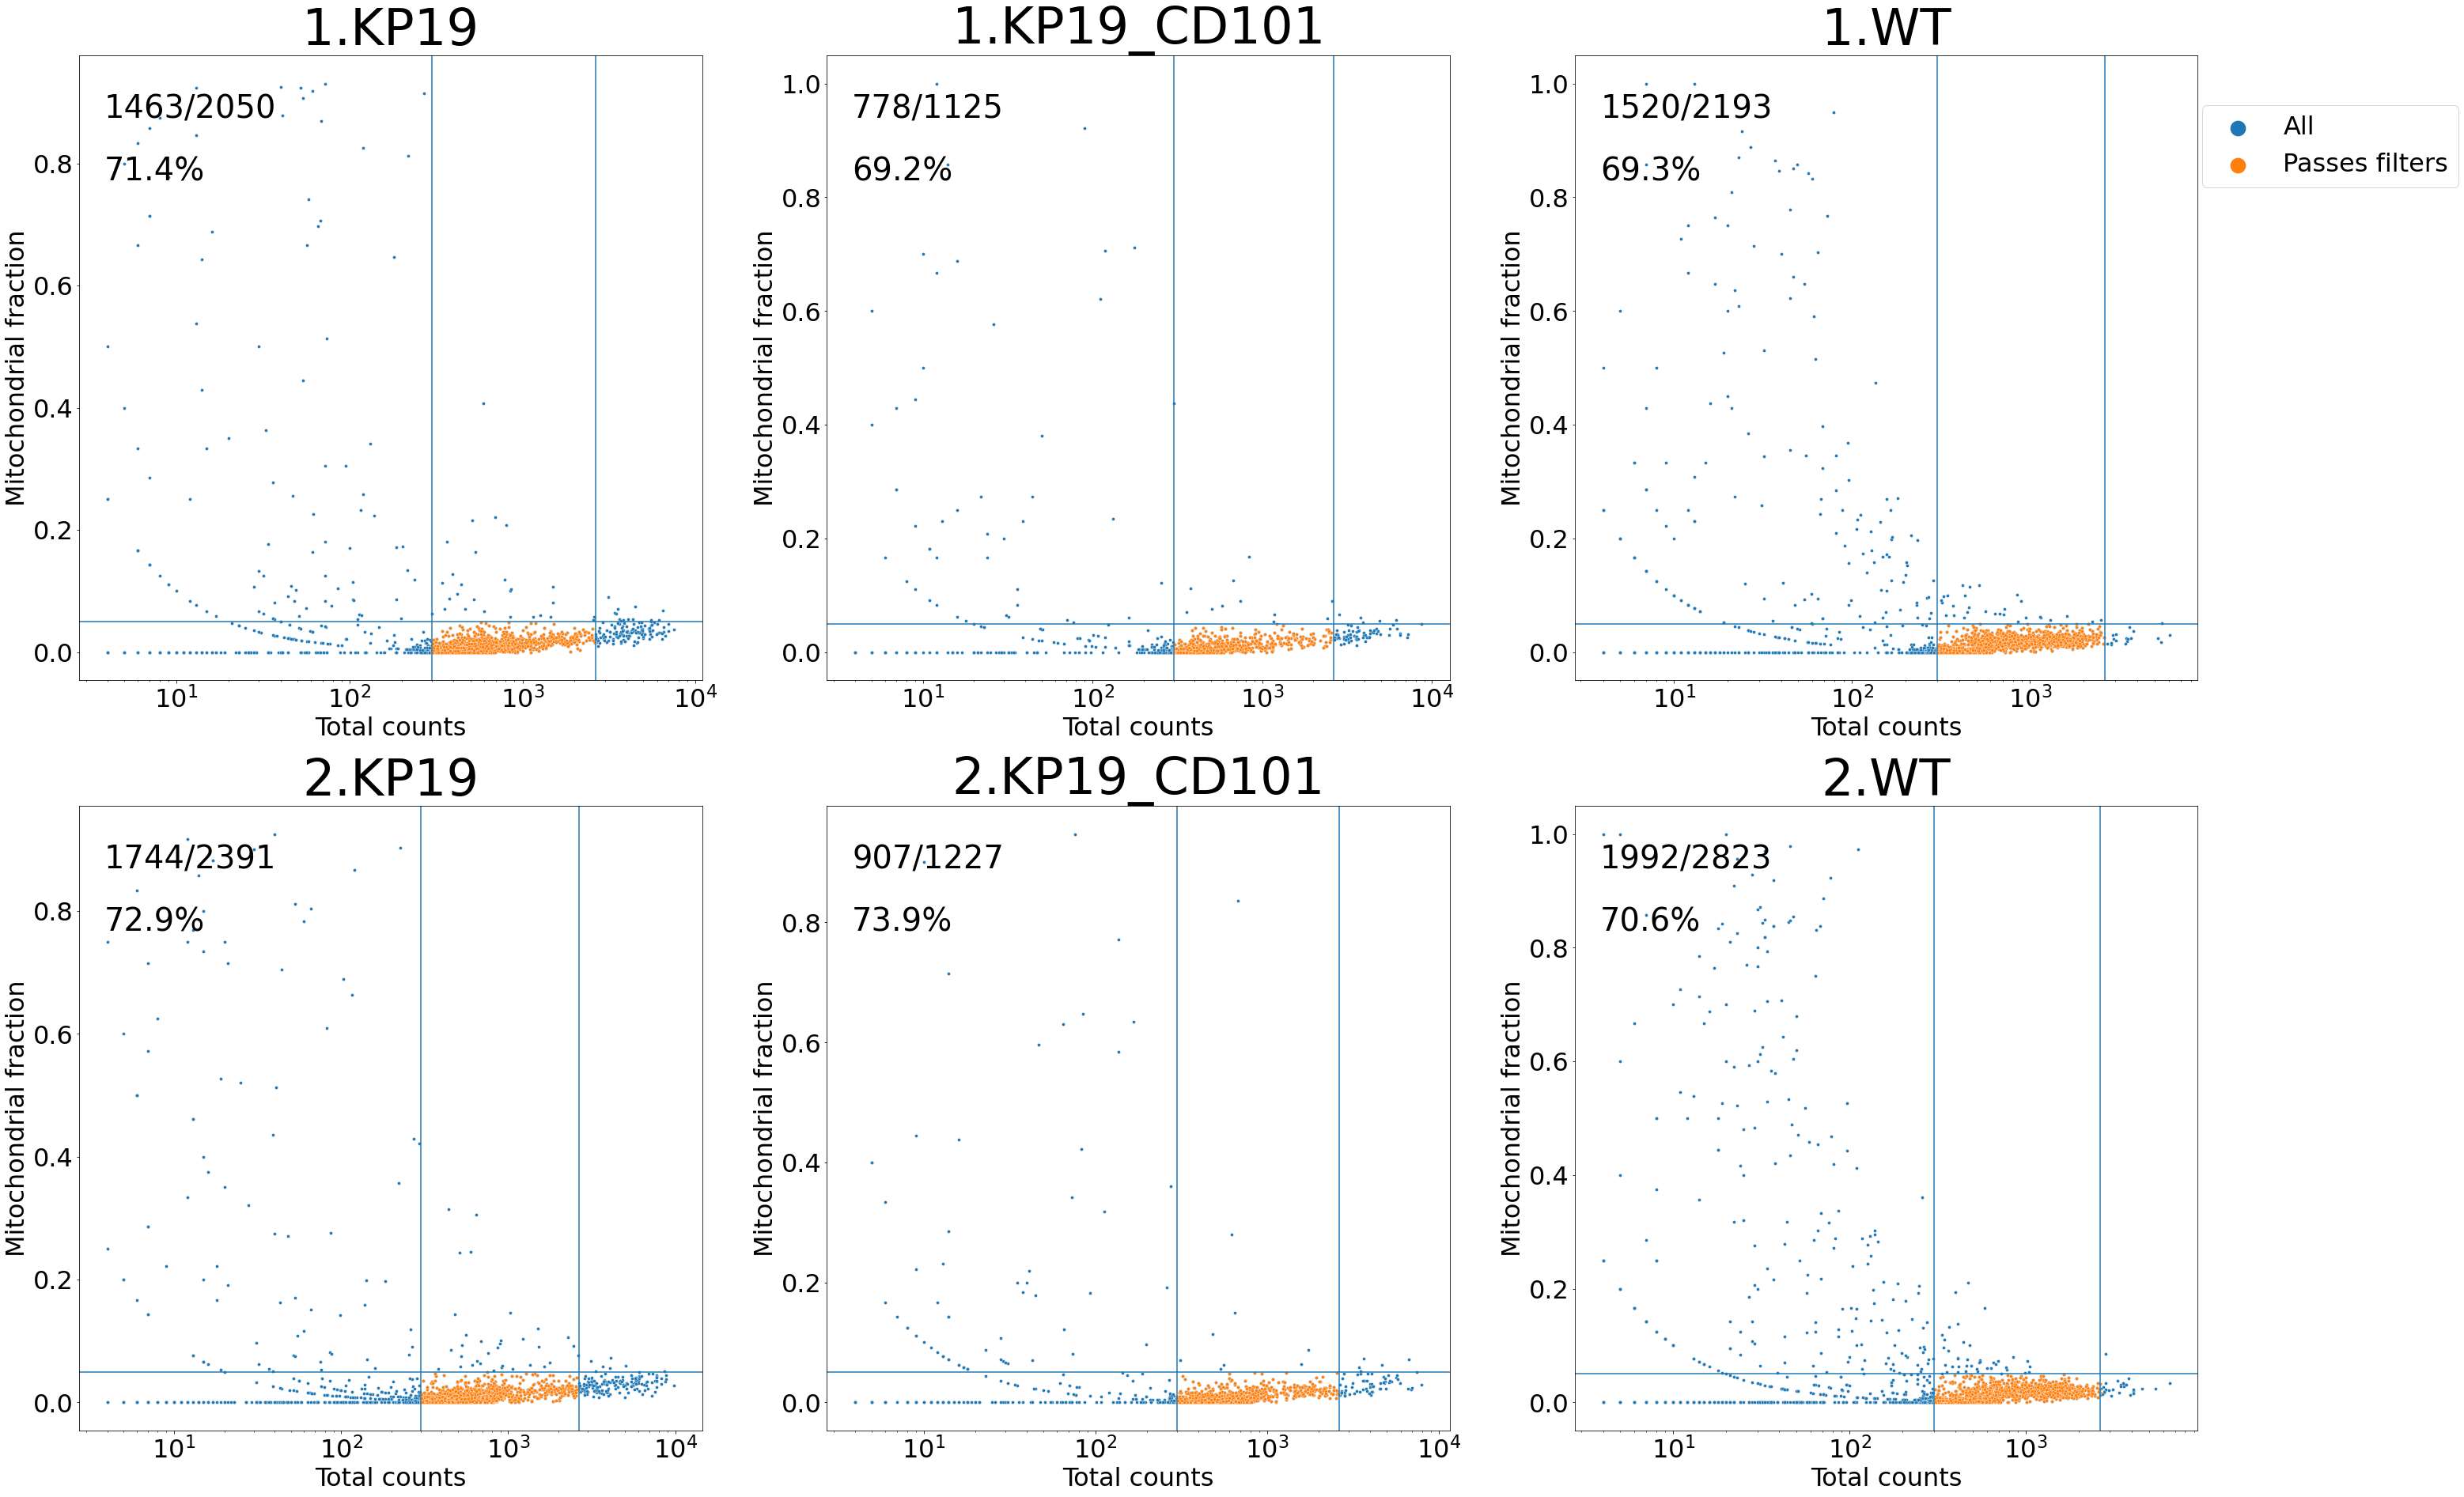

In [34]:
rnadict_keys = [*rnadict.keys()]
n_libraries = len(rnadict_keys)
plot_scale_factor = 8 if n_libraries < 5 else 16

mito_filter = 0.05
filter_var = 'n_counts'

n_cols = n_libraries if n_libraries < 5 else int(np.ceil(n_libraries/2))

n_rows = n_libraries//4 + 1


rnadict_filt = {}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(plot_scale_factor*n_cols,plot_scale_factor*n_rows))

for i, ax in enumerate(axes.ravel()):
    if i == n_libraries: continue
    
    
    umi_min = 300 #np.ceil(np.percentile(adata.obs[filter_var], 5)).astype(int)
    umi_max = np.ceil(np.percentile(adata.obs[filter_var], 99)).astype(int)

    
    
       
    pass_filter_mask = (rnadict[rnadict_keys[i]].obs['mito_fraction'] < mito_filter) & (rnadict[rnadict_keys[i]].obs[filter_var] > umi_min) & (rnadict[rnadict_keys[i]].obs[filter_var] < umi_max)
    filtered = rnadict[rnadict_keys[i]][pass_filter_mask]
    
    rnadict_filt[rnadict_keys[i]] = filtered
        
    sns.scatterplot(data=rnadict[rnadict_keys[i]].obs, x=filter_var, y='mito_fraction', s=1*plot_scale_factor, ax=ax, color=ng.blue, label='All' if i==0 else '', legend= False)
    sns.scatterplot(data=filtered.obs, x=filter_var, y='mito_fraction', s=1*plot_scale_factor, ax=ax, color=ng.orange, label='Passes filters' if i==0 else '', legend=False)


    ax.set_xscale('log')
    ax.set_title(rnadict_keys[i], fontsize= 4*plot_scale_factor)
    ax.set_xlabel('Total counts', fontsize= 2*plot_scale_factor)
    ax.set_ylabel('Mitochondrial fraction', fontsize=2*plot_scale_factor)
    ax.tick_params(labelsize=2*plot_scale_factor)
    
    ax.axhline(mito_filter)
    ax.axvline(umi_min)
    ax.axvline(umi_max)
    
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())    
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.01), yl[0] + yl.ptp() * 0.9, '{}/{}'.format(len(filtered.obs), len(rnadict[rnadict_keys[i]])), fontsize=2.5*plot_scale_factor)
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.01), yl[0] + yl.ptp() * 0.8, '{:.1f}%'.format(len(filtered.obs)/len(rnadict[rnadict_keys[i]])*100), fontsize=2.5*plot_scale_factor)
    

fig.legend(loc=7, bbox_to_anchor=(1,0.83), fontsize=2*plot_scale_factor, markerscale=5)
plt.show()


# UMI

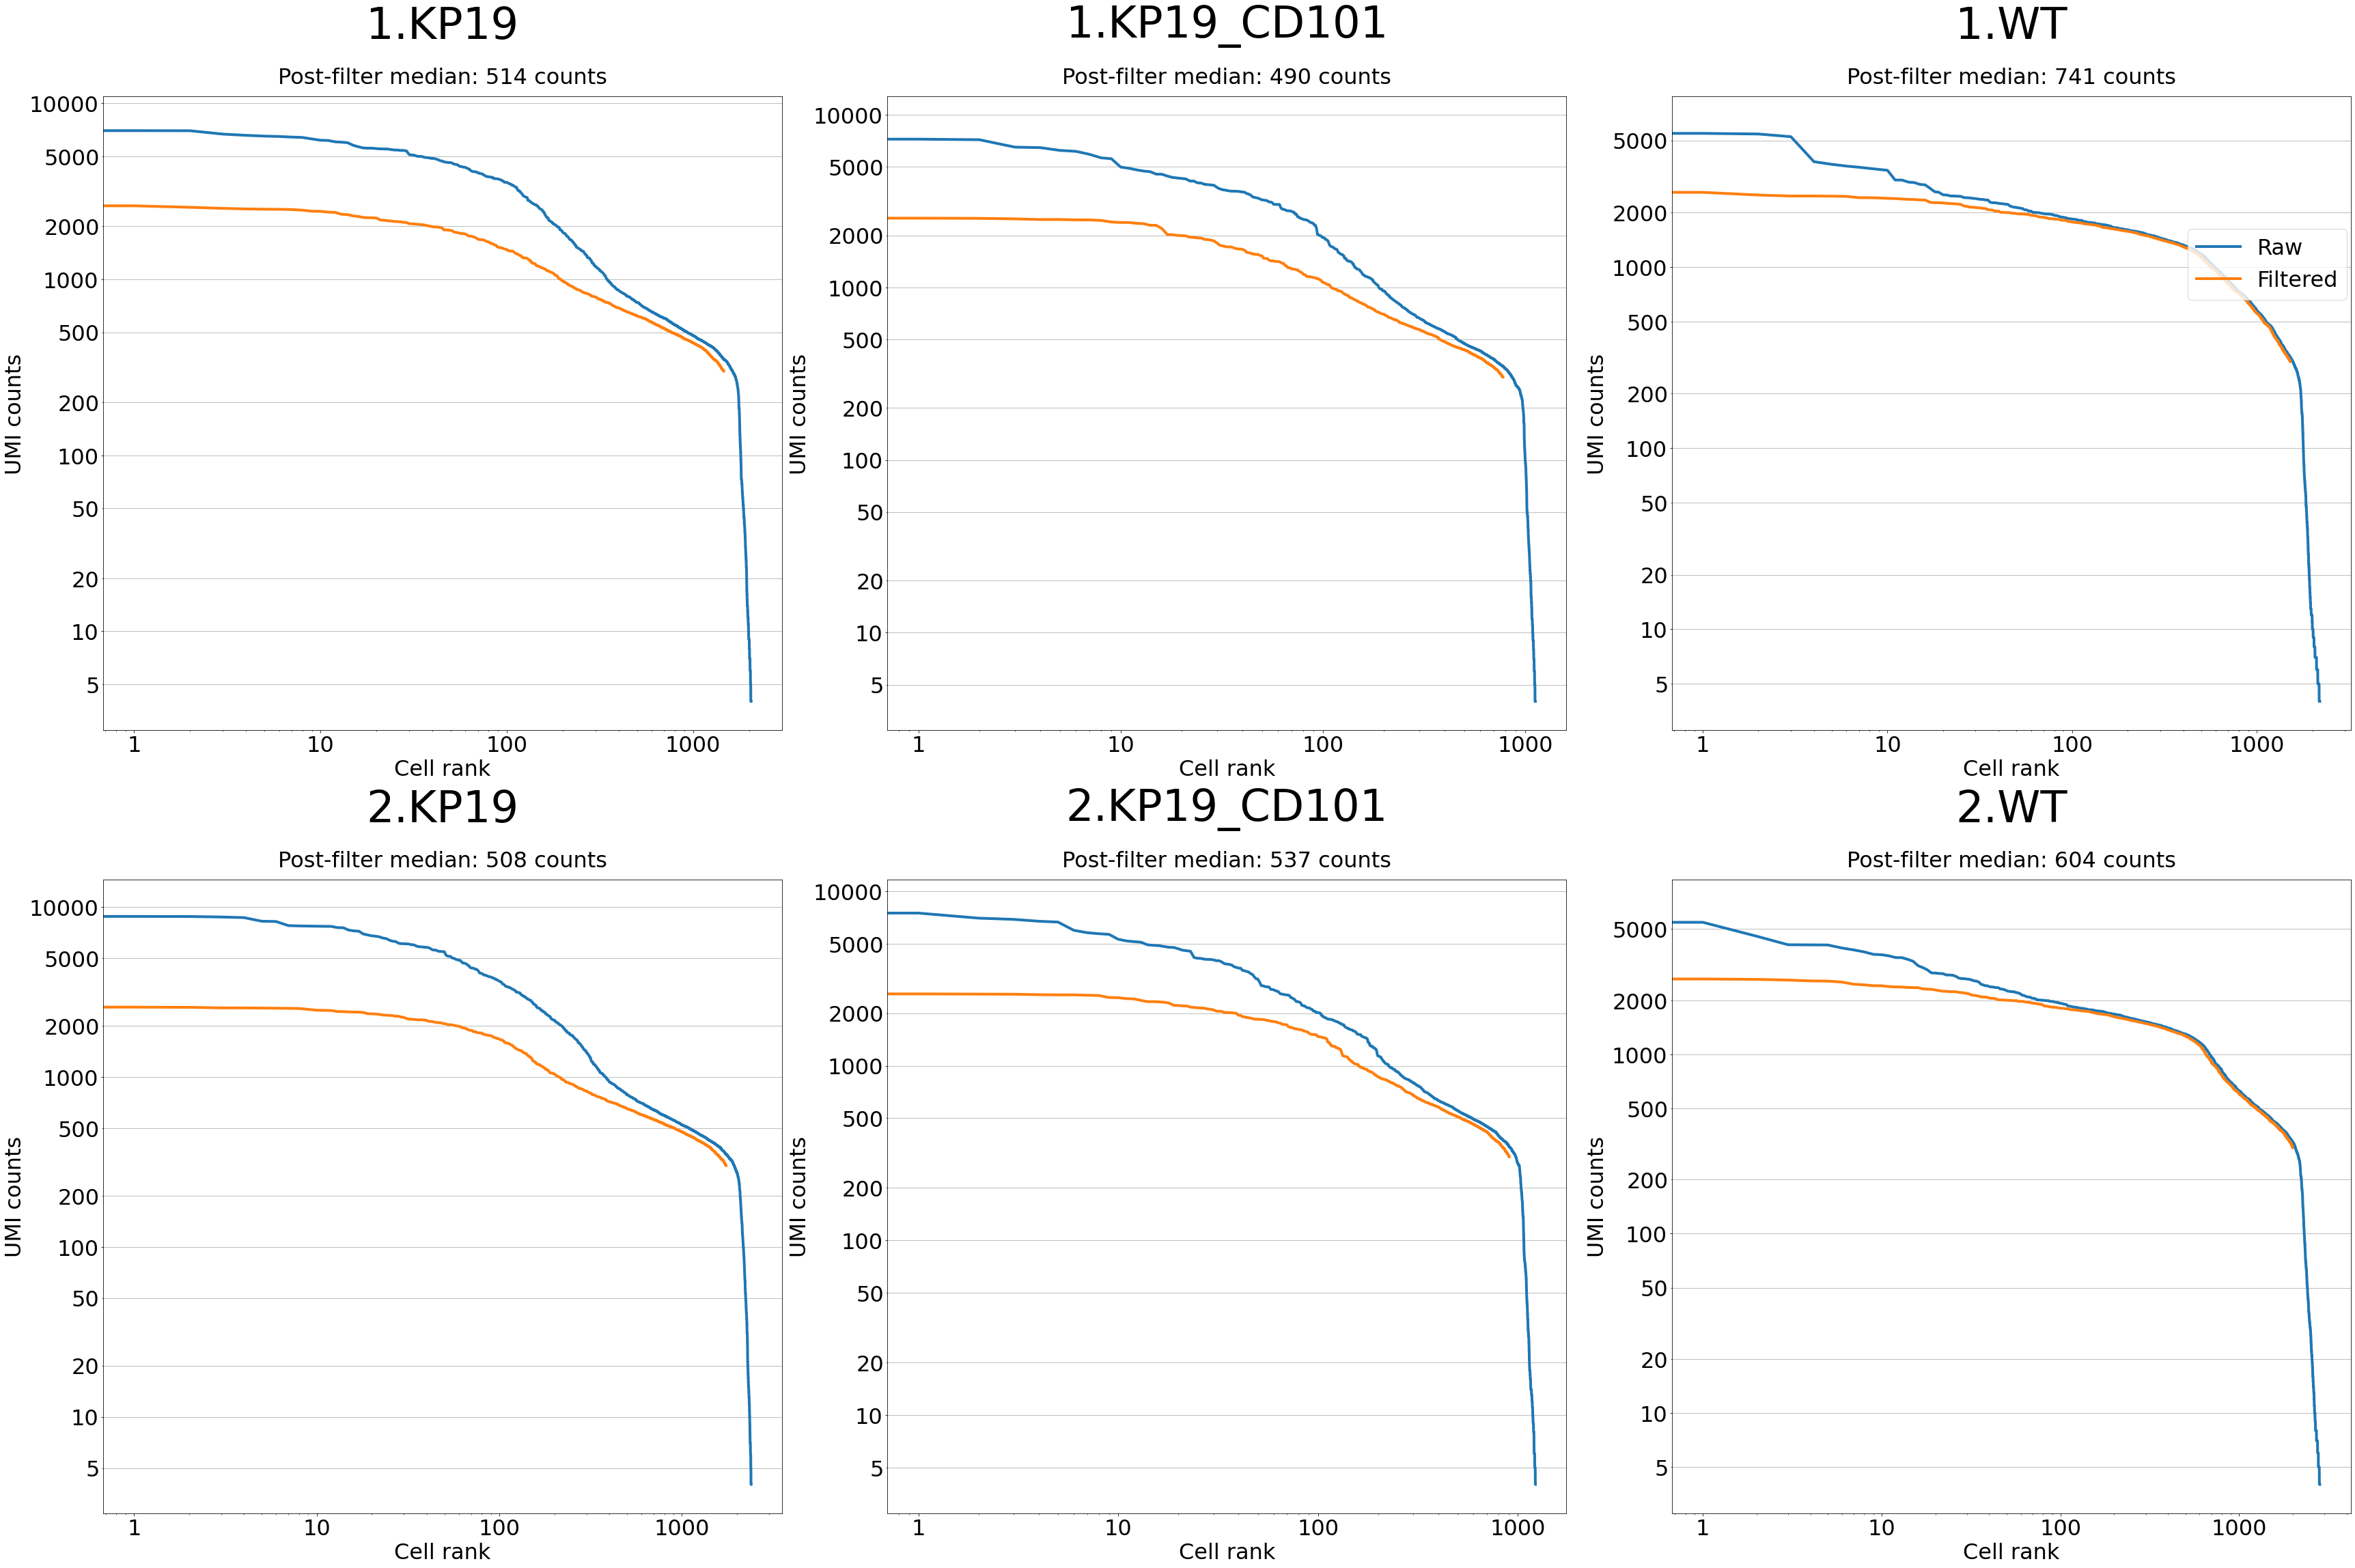

In [35]:
rnadict_keys = [*rnadict.keys()]
n_libraries = len(rnadict_keys)
plot_scale_factor = 8 if n_libraries < 5 else 16

mito_filter = 0.05
filter_var = 'n_counts'

n_cols = n_libraries if n_libraries < 5 else int(np.ceil(n_libraries/2))
n_rows = n_libraries//4 + 1


fig, axes = plt.subplots(n_rows, n_cols, figsize=(plot_scale_factor*n_cols,plot_scale_factor*n_rows))

for i, ax in enumerate(axes.ravel()):
    if i == n_libraries: continue

    sorted_filtered_counts = np.sort(rnadict_filt[rnadict_keys[i]].obs[filter_var])[::-1]
    median_filtered_counts = int(np.median(sorted_filtered_counts))

    ax.plot((np.sort(rnadict[rnadict_keys[i]].obs[filter_var])[::-1]), lw=4, label='Raw' if i==0 else '')
    ax.plot(sorted_filtered_counts, lw=4, label='Filtered' if i==0 else '')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(rnadict_keys[i]+'\n', fontsize= 4*plot_scale_factor)
    ax.text(x=0.5, y=1.02, s= 'Post-filter median: {} counts'.format(median_filtered_counts), fontsize=2*plot_scale_factor, ha="center", transform=ax.transAxes)

    ax.set_xlabel('Cell rank', fontsize= 2*plot_scale_factor)
    ax.set_ylabel('UMI counts', fontsize=2*plot_scale_factor)
    
    ax.tick_params(labelsize=2*plot_scale_factor)
    ax.tick_params(axis='y', which='minor', labelsize=2*plot_scale_factor)
    
    ax.yaxis.set_minor_formatter(mpl.ticker.FormatStrFormatter("%d"))
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=[1, 2.0,5.0]))
    ax.grid(which='both', axis='y')


fig.legend(loc=7, bbox_to_anchor=(1,0.83), fontsize=2*plot_scale_factor, markerscale=5)
plt.tight_layout()
plt.show()


# N_genes

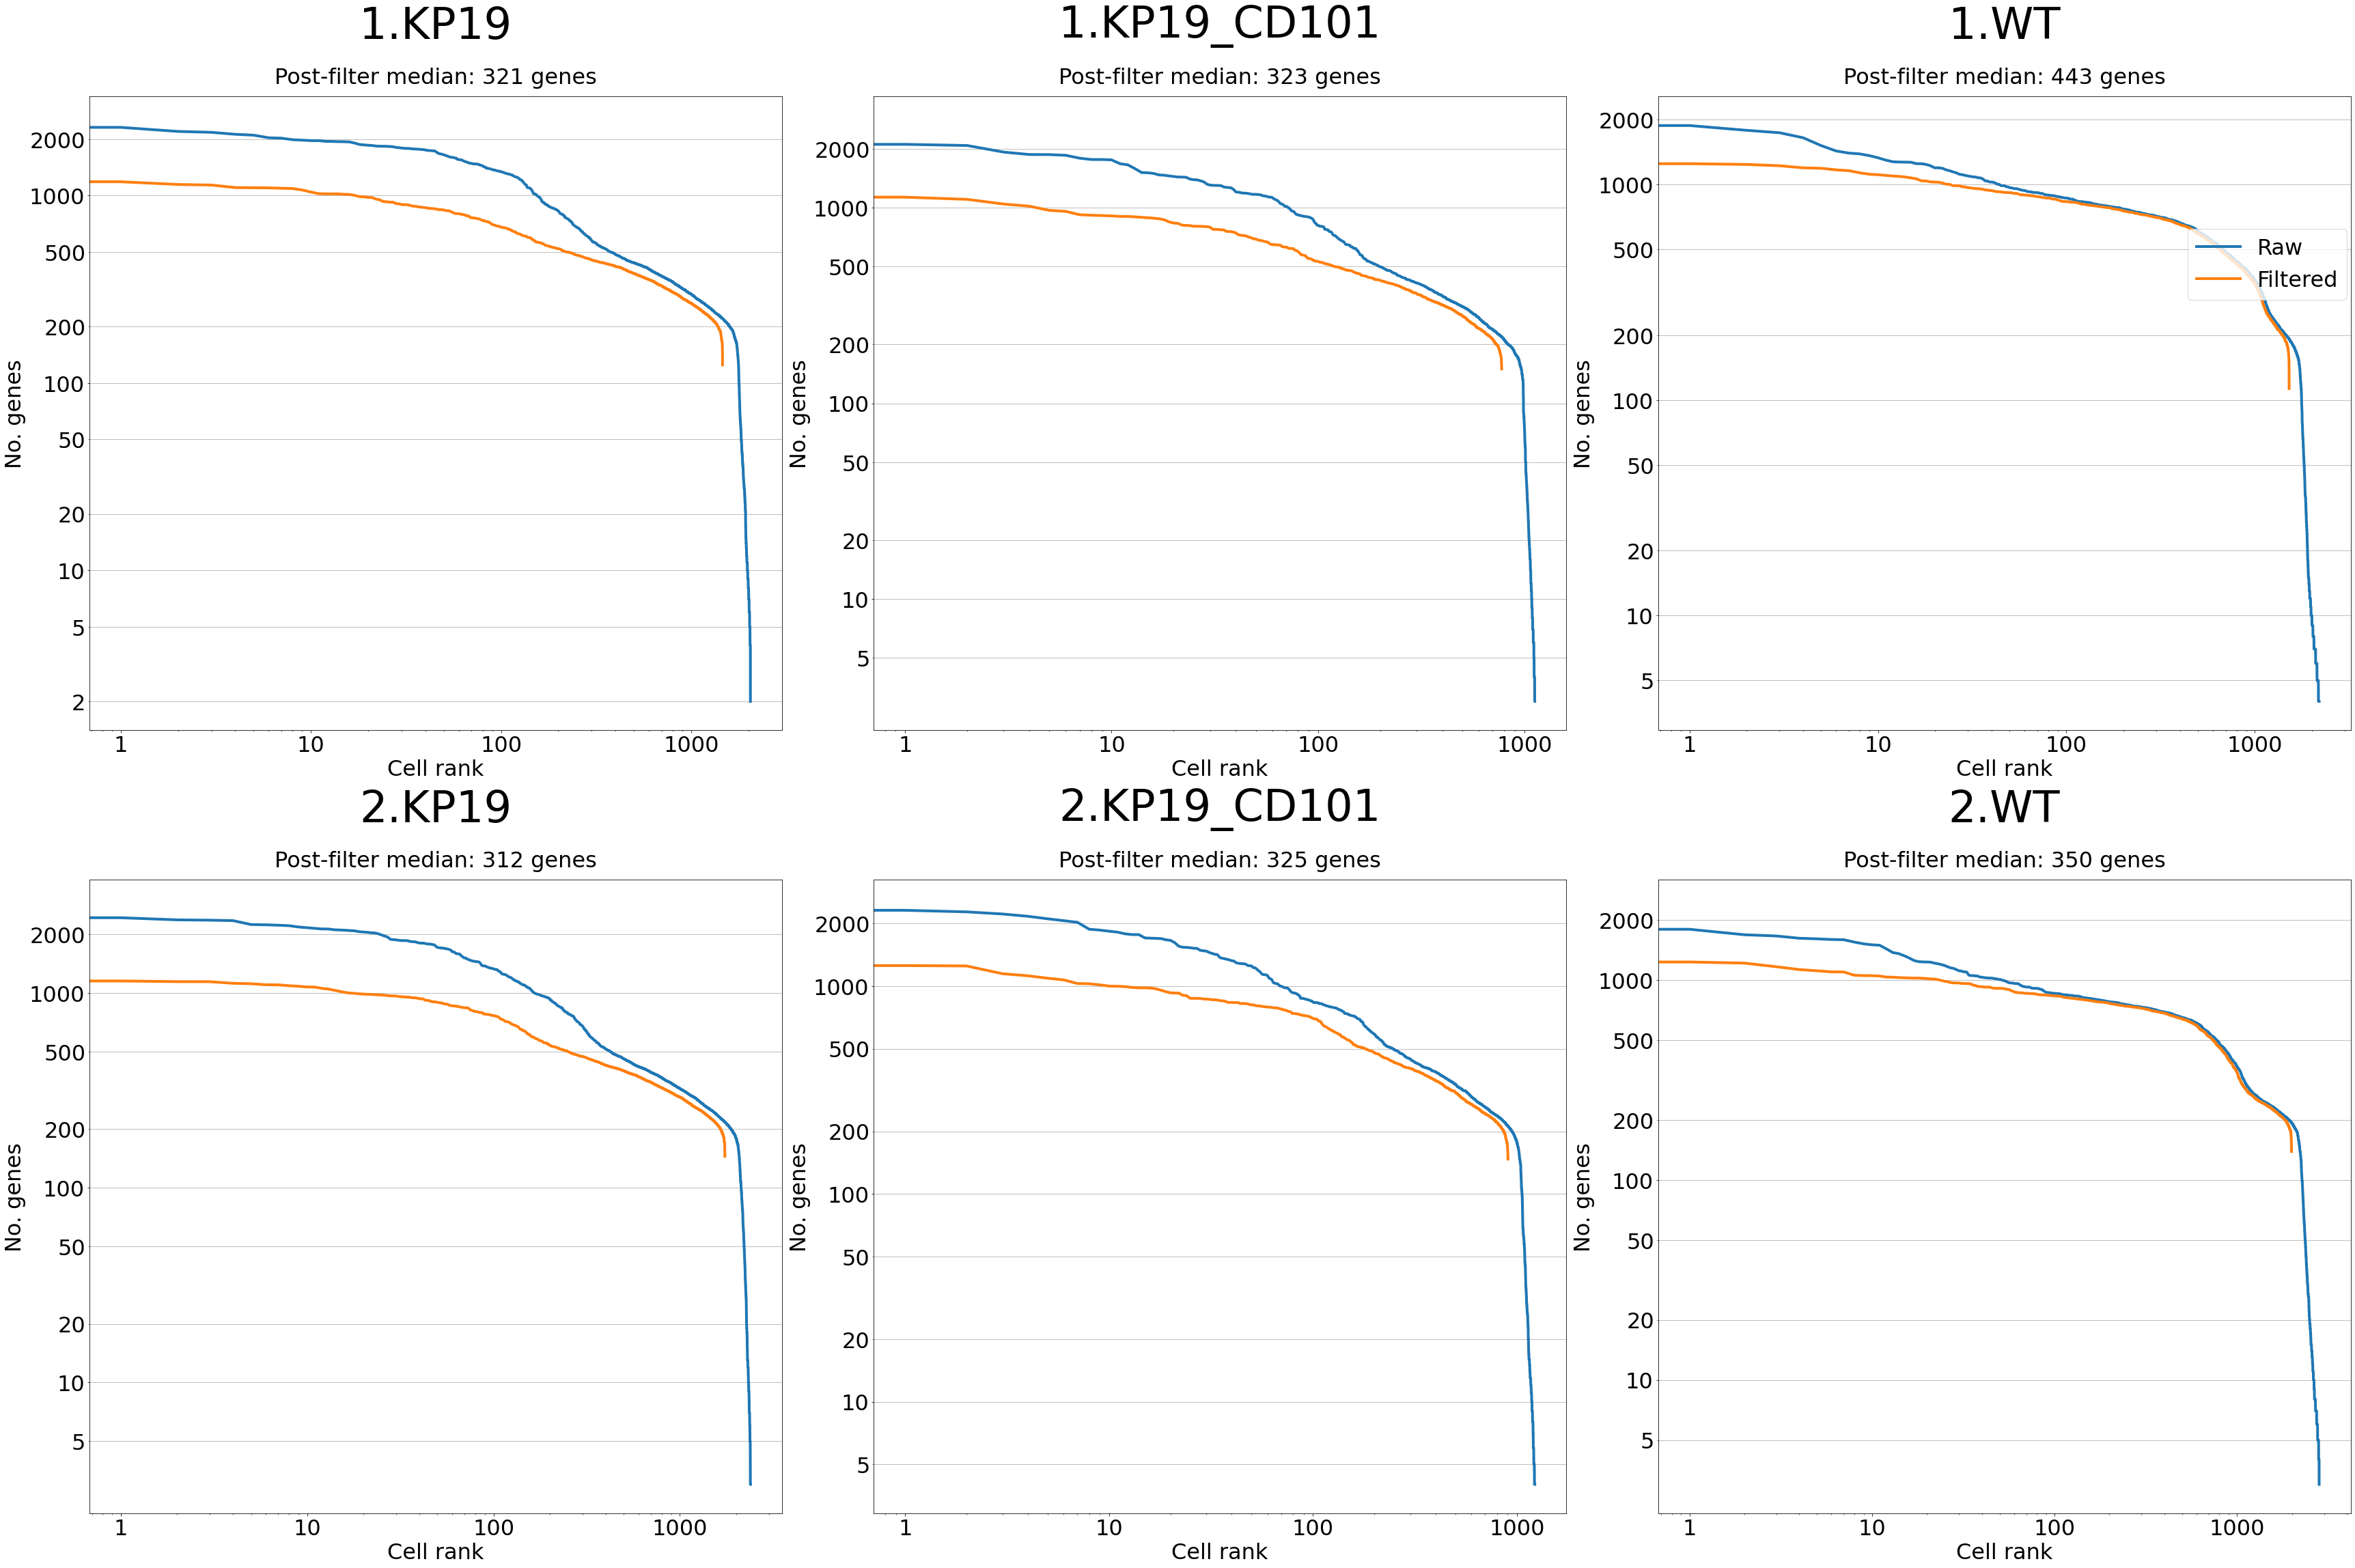

In [36]:
rnadict_keys = [*rnadict.keys()]
n_libraries = len(rnadict_keys)
plot_scale_factor = 8 if n_libraries < 5 else 16

mito_filter = 0.05
filter_var = 'n_genes'

n_cols = n_libraries if n_libraries < 5 else int(np.ceil(n_libraries/2))
n_rows = n_libraries//4 + 1


fig, axes = plt.subplots(n_rows, n_cols, figsize=(plot_scale_factor*n_cols,plot_scale_factor*n_rows))

for i, ax in enumerate(axes.ravel()):
    if i == n_libraries: continue

    sorted_filtered_counts = np.sort(rnadict_filt[rnadict_keys[i]].obs[filter_var])[::-1]
    median_filtered_counts = int(np.median(sorted_filtered_counts))

    ax.plot((np.sort(rnadict[rnadict_keys[i]].obs[filter_var])[::-1]), lw=4, label='Raw' if i==0 else '')
    ax.plot(sorted_filtered_counts, lw=4, label='Filtered' if i==0 else '')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(rnadict_keys[i]+'\n', fontsize= 4*plot_scale_factor)
    ax.text(x=0.5, y=1.02, s= 'Post-filter median: {} genes'.format(median_filtered_counts), fontsize=2*plot_scale_factor, ha="center", transform=ax.transAxes)

    ax.set_xlabel('Cell rank', fontsize= 2*plot_scale_factor)
    ax.set_ylabel('No. genes', fontsize=2*plot_scale_factor)
    ax.tick_params(labelsize=2*plot_scale_factor)
    ax.tick_params(axis='y', which='minor', labelsize=2*plot_scale_factor)
    
    
    ax.yaxis.set_minor_formatter(mpl.ticker.FormatStrFormatter("%d"))
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,subs=[1, 2.0,5.0]))
    ax.grid(which='both', axis='y')
    


fig.legend(loc=7, bbox_to_anchor=(1,0.83), fontsize=2*plot_scale_factor, markerscale=5)
plt.tight_layout()
plt.show()


In [52]:
rnadata_filt = sc.concat(rnadict_filt)
adt_df = pd.DataFrame(adtdata.X.todense(), columns=adtdata.var['EnsemblID'].rename(None), index=adtdata.obs_names)
rnadata_filt.obs = rnadata_filt.obs.join(adt_df)

# Save

In [56]:
start = time()
fname = '/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_neutrophils_untreated_{}x{}_backup_{}.h5ad'.format(*rnadata_filt.shape,ng.now())
rnadata_filt.write(fname)
print(fname)
ng.print_etime(start)

/n/groups/klein/nico/neutrophils/backups/totalseq_exp2_neutrophils_untreated_8404x32285_backup_211208_11h04.h5ad
Elapsed time: 0 minutes and 0.7 seconds.
